# Bayesian analysis of the empirical saturation point (refactored version)

In [96]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Performing Bayesian linear regression on EFT predictions (Coester Band)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 24 seconds.


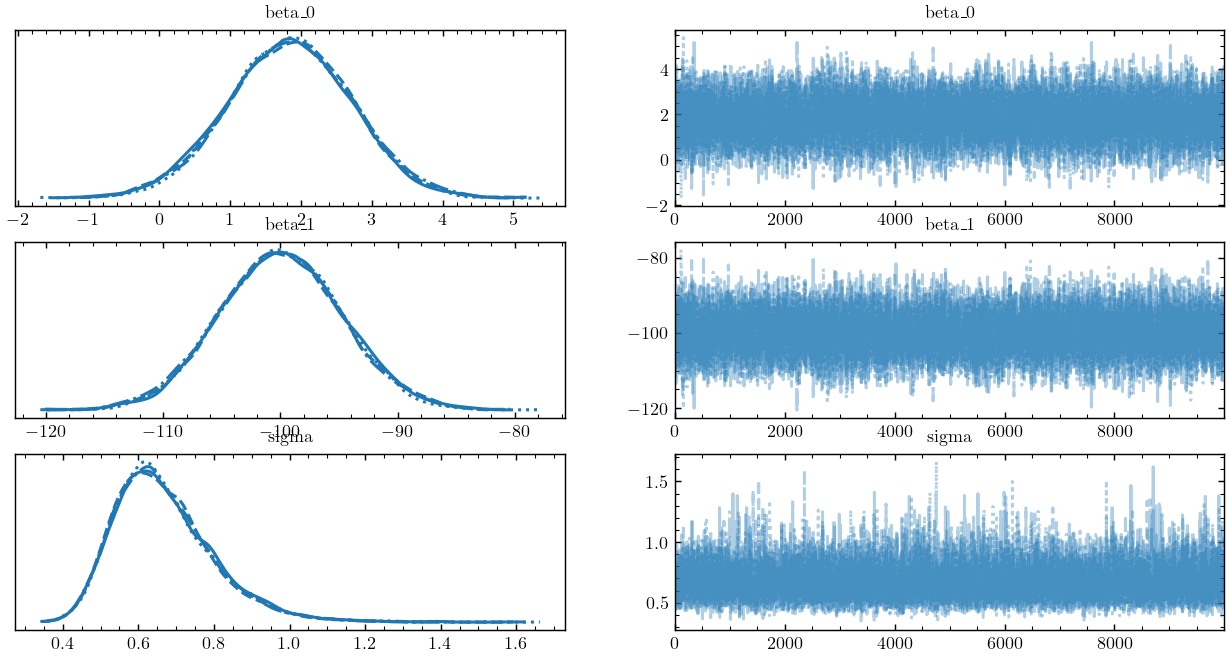

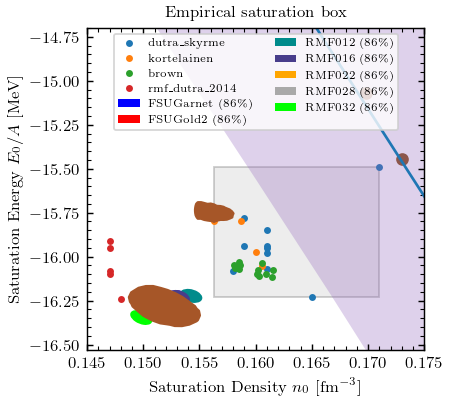

In [97]:
from modules.SaturationAnalysis import SaturationAnalysis
analysis = SaturationAnalysis()
analysis.plot_contraints(eft=True, eft_conf_level=0.95)

## Priors

Let's take a look at the priors used in this work. They can be specified in the file `modules/priors.py`.

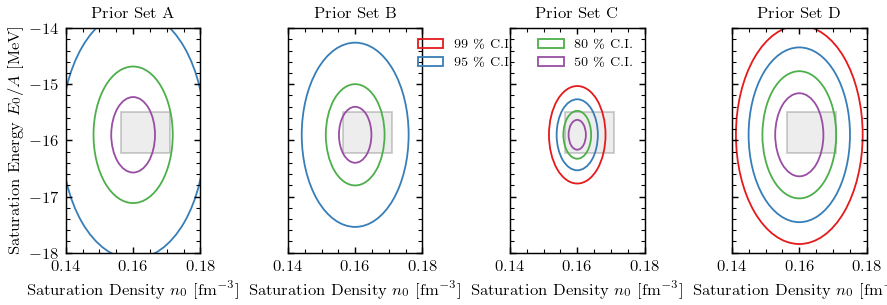

In [131]:
from modules.SaturationAnalysis import visualize_priors
from modules.priors import *
visualize_priors(used_prior_sets)

We use an uninformed prior (left) and an informed prior (right) and something in between (center panel) to investigate the prior sensitivity of our Bayesian inference.

## Hierarchical model

In [115]:
from modules.DataSets import DataSetSampleConfig, Scenario
from modules.SaturationAnalysis import DEFAULT_DFT_CONSTRAINTS as dft_constraints
scenario1 = Scenario(label="FSU-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"])])
scenario2 = Scenario(label="FSU+Schunck-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["FSU"]),
                              DataSetSampleConfig(data_set=dft_constraints["Schunck"])])
scenario3 = Scenario(label="all",
                     configs=[DataSetSampleConfig(data_set=dft_constraints[lbl]) for lbl in dft_constraints.keys()])
scenario4 = Scenario(label="Giuliani+Schunck-only",
                     configs=[DataSetSampleConfig(data_set=dft_constraints["Giuliani"]),
                              DataSetSampleConfig(data_set=dft_constraints["Schunck"])])

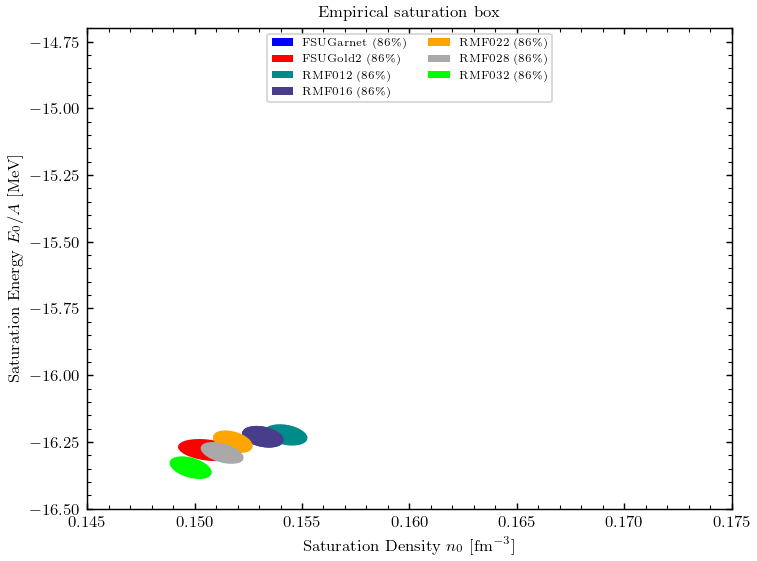

In [116]:
scenario1.configs[0].data_set.plot()

MC sampling: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


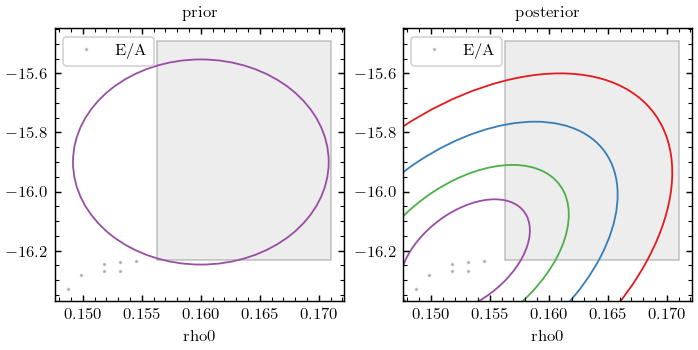

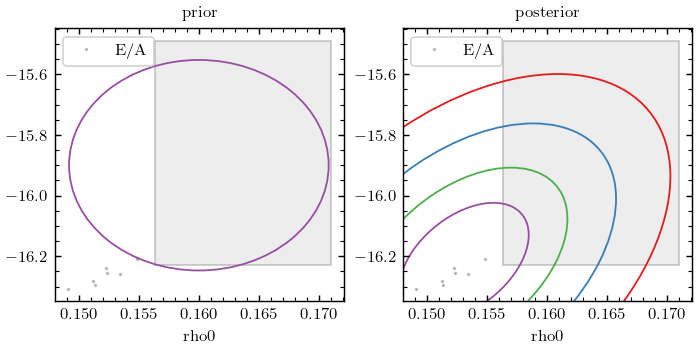

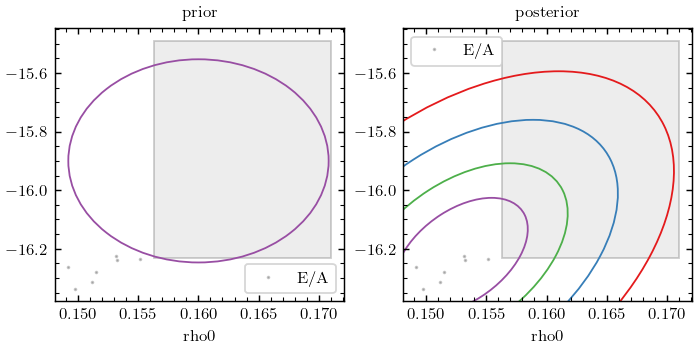

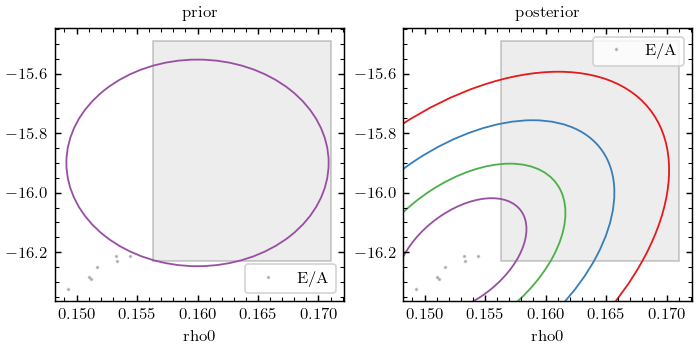

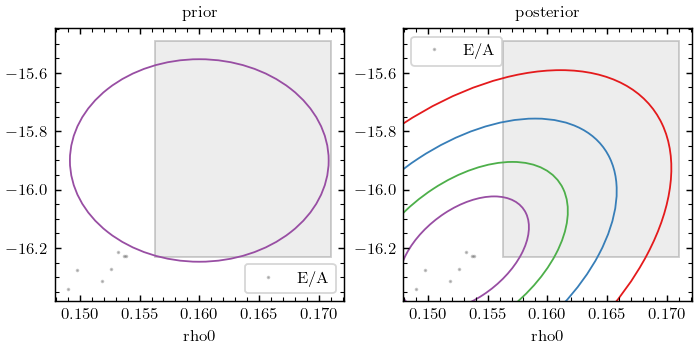

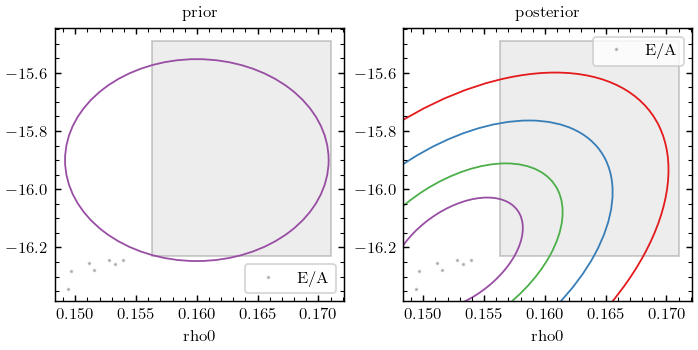

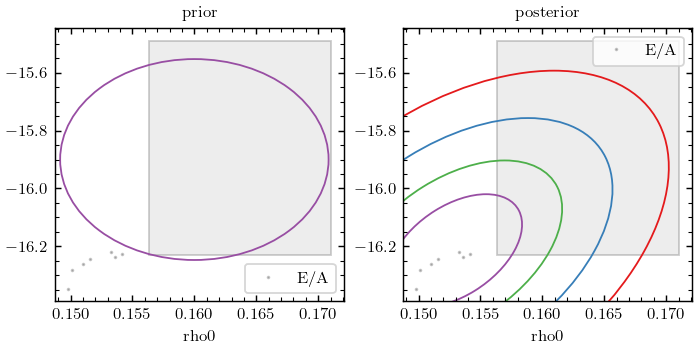

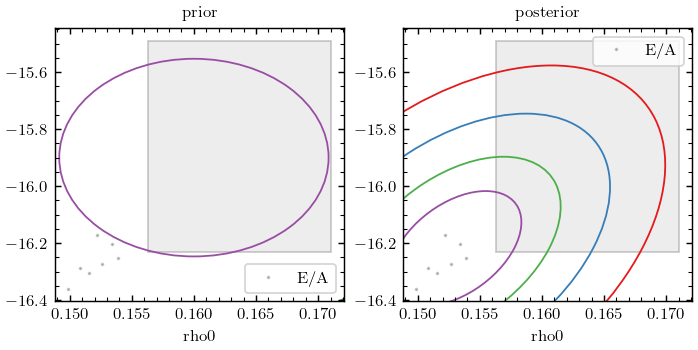

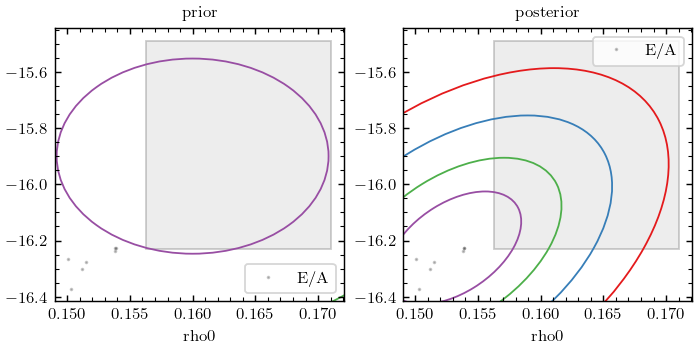

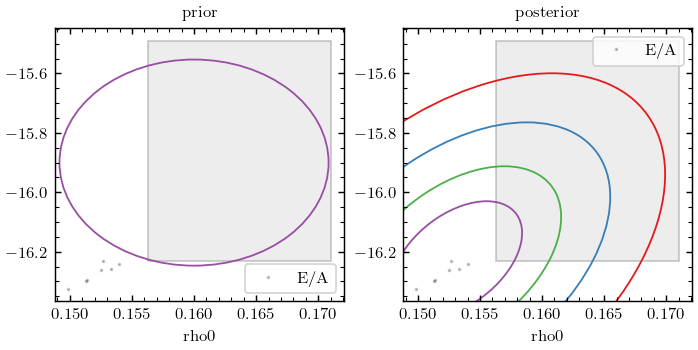

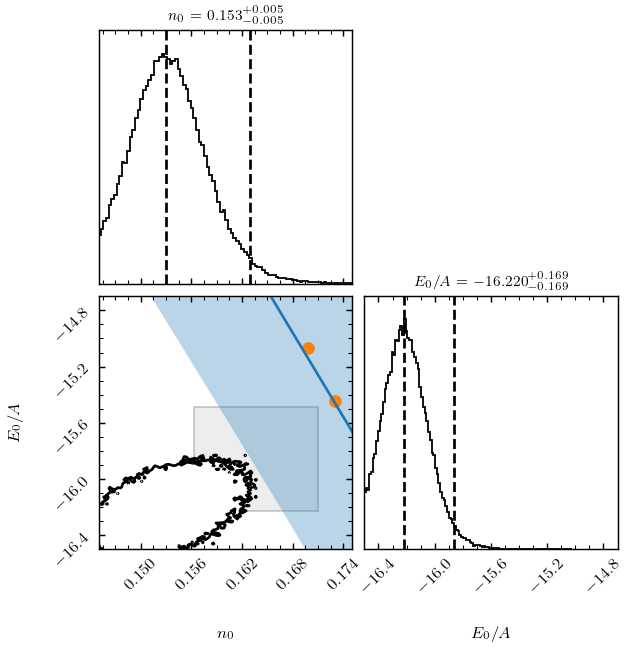

In [132]:
analysis.multiverse(scenario1, prior_params=standard_prior_params)

In [ ]:
analysis.multiverse(scenario2)

In [ ]:
analysis.multiverse(scenario3)

In [ ]:
analysis.multiverse(scenario4)

In [ ]:
analysis.plot_individual_models()